In [1]:
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-3qj5g2ap
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmp/pip-req-build-3qj5g2ap
  Resolved https://github.com/tensorflow/docs to commit 159143b05575c90bc1217bfa99c76cb5ca27b8d4
  Preparing metadata (setup.py) ... done


In [2]:
import os
from tensorflow_docs.vis import embed
from tensorflow import keras
from keras.callbacks import EarlyStopping

from imutils import paths

import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import imageio
import cv2
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

2023-10-25 02:37:10.574593: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-25 02:37:10.609706: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-25 02:37:10.609740: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-25 02:37:10.609767: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-25 02:37:10.616341: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-25 02:37:10.617232: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

In [27]:
IMG_SIZE = 224
BATCH_SIZE = 128
EPOCHS = 300
LEARNING_RATE = 0.0001
MAX_SEQ_LENGTH = 50
NUM_FEATURES = 2048

In [16]:
train_csv = "/home/khanhhiep/Code/lsa64_rnn/LSA64_videos_simple_signer_independent_train.csv"
test_csv = "/home/khanhhiep/Code/lsa64_rnn/LSA64_videos_simple_signer_independent_test.csv"
train_videos = "/home/khanhhiep/Code/lsa64_rnn/Signer_Independent_data/Signer_Independent_Splits_Simple/train"
test_videos = "/home/khanhhiep/Code/lsa64_rnn/Signer_Independent_data/Signer_Independent_Splits_Simple/test"

In [18]:
train_df = pd.read_csv(train_csv)
test_df = pd.read_csv(test_csv)

print(f"Total videos for training: {len(train_df)}")
print(f"Total videos for testing: {len(test_df)}")

# train_df.sample(4)
print(train_df)
print(test_df)

Total videos for training: 160
Total videos for testing: 40
     Unnamed: 0       video_name class_name
0             0  004_003_001.mp4     Yellow
1             1  001_004_001.mp4     Opaque
2             2  003_007_003.mp4      Green
3             3  003_003_001.mp4      Green
4             4  002_009_001.mp4        Red
..          ...              ...        ...
155         155  001_003_003.mp4     Opaque
156         156  001_004_002.mp4     Opaque
157         157  001_001_005.mp4     Opaque
158         158  002_003_002.mp4        Red
159         159  004_004_002.mp4     Yellow

[160 rows x 3 columns]
    Unnamed: 0       video_name class_name
0            0  003_010_004.mp4      Green
1            1  001_010_001.mp4     Opaque
2            2  004_005_004.mp4     Yellow
3            3  001_005_005.mp4     Opaque
4            4  001_005_002.mp4     Opaque
5            5  001_005_001.mp4     Opaque
6            6  004_005_001.mp4     Yellow
7            7  001_010_003.mp4     Opaque
8

In [19]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [20]:
def crop_center_square(frame):
    y, x = frame.shape[0:2]
    min_dim = min(y, x)
    start_x = (x // 2) - (min_dim // 2)
    start_y = (y // 2) - (min_dim // 2)
    return frame[start_y : start_y + min_dim, start_x : start_x + min_dim]

In [21]:
def load_video(path, max_frames=10, resize=(IMG_SIZE, IMG_SIZE)):
    cap = cv2.VideoCapture(path)
    frames = []
    cap.set(cv2.CAP_PROP_FPS, 10)
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = crop_center_square(frame)
            frame = cv2.resize(frame, resize)
            frame = frame[:, :, [2, 1, 0]]
            frames.append(frame)

            if len(frames) == max_frames:
                break
    finally:
        cap.release()
    return np.array(frames)

In [22]:
def build_feature_extractor():
    feature_extractor = keras.applications.InceptionV3(
        weights="imagenet",
        include_top=False,
        pooling="avg",
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
    )
    
    preprocess_input = keras.applications.inception_v3.preprocess_input

    inputs = keras.Input((IMG_SIZE, IMG_SIZE, 3))
    preprocessed = preprocess_input(inputs)

    outputs = feature_extractor(preprocessed)
#     print(feature_extractor.summary())
    return keras.Model(inputs, outputs, name="feature_extractor")

In [23]:
feature_extractor = build_feature_extractor()

In [24]:
# convert the label names to integers

label_processor = keras.layers.StringLookup(
    num_oov_indices=0, vocabulary=np.unique(train_df["class_name"])
)
print(label_processor.get_vocabulary())

['Green', 'Opaque', 'Red', 'Yellow']


In [28]:
def prepare_all_videos(df, root_dir):
    num_samples = len(df)
    video_paths = df["video_name"].values.tolist()
    labels = df["class_name"].values
    labels = label_processor(labels[..., None]).numpy()

    # `frame_masks` and `frame_features` are what we will feed to our sequence model.
    # `frame_masks` will contain a bunch of booleans denoting if a timestep is
    # masked with padding or not.
    frame_masks = np.zeros(shape=(num_samples, MAX_SEQ_LENGTH), dtype="bool")
    frame_features = np.zeros(
        shape=(num_samples, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
    )

    # For each video.
    print('Getting frames and extracting features...')
    for idx, path in enumerate(video_paths):
        # Gather all its frames and add a batch dimension.
        if idx%100 == 0:
            print(idx)
        frames = load_video(os.path.join(root_dir, path))
        frames = frames[None, ...]

        # Initialize placeholders to store the masks and features of the current video.
        temp_frame_mask = np.zeros(
            shape=(
                1,
                MAX_SEQ_LENGTH,
            ),
            dtype="bool",
        )
        temp_frame_features = np.zeros(
            shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
        )

        # Extract features from the frames of the current video.
        for i, batch in enumerate(frames):
            video_length = batch.shape[0]
            length = min(MAX_SEQ_LENGTH, video_length)
            for j in range(length):
                temp_frame_features[i, j, :] = feature_extractor.predict(
                    batch[None, j, :]
                )
            temp_frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked

        frame_features[
            idx,
        ] = temp_frame_features.squeeze()
        frame_masks[
            idx,
        ] = temp_frame_mask.squeeze()

    return (frame_features, frame_masks), labels

In [29]:
train_data, train_labels = prepare_all_videos(train_df, train_videos)
test_data, test_labels = prepare_all_videos(test_df, test_videos)

print(f"Frame features in train set: {train_data[0].shape}")
print(f"Frame masks in train set: {train_data[1].shape}")

Getting frames and extracting features...
0
1/1 [==============================] - 0s 50ms/step


1/1 [==============================] - 0s 42ms/step
100
1/1 [==============================] - 0s 47ms/step
Getting frames and extracting features...
0
1/1 [==============================] - 0s 43ms/step
Frame features in train set: (160, 50, 2048)
Frame masks in train set: (160, 50)


In [71]:
from keras import models, layers

In [30]:
# Utility for our sequence model.
def get_sequence_model():
    class_vocab = label_processor.get_vocabulary()
    print(len(class_vocab))
    

    frame_features_input = keras.Input((MAX_SEQ_LENGTH, NUM_FEATURES))
    mask_input = keras.Input((MAX_SEQ_LENGTH,), dtype="bool")
    # Refer to the following tutorial to understand the significance of using `mask`:
    # https://keras.io/api/layers/recurrent_layers/gru/
    x = keras.layers.GRU(units=64, return_sequences=True)(frame_features_input, mask=mask_input)
    x = keras.layers.Dropout(0.2)(x)

    x = keras.layers.GRU(units=128)(x)
    x = keras.layers.Dropout(0.2)(x)
    
    x = keras.layers.Dense(128, activation='softmax')(x)


    output = keras.layers.Dense(len(class_vocab), activation="softmax")(x)

    rnn_model = keras.Model([frame_features_input, mask_input], output)

    rnn_model.compile(
        loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
    )
    return rnn_model

In [31]:
def run_experiment():
    filepath = "./tmp/video_classifier"
    checkpoint = keras.callbacks.ModelCheckpoint(
        filepath, save_weights_only=True, save_best_only=True, verbose=1
    )
    earlystopping = EarlyStopping(monitor='val_accuracy', mode='max', patience=50, restore_best_weights=True, verbose=2)

    seq_model = get_sequence_model()
    print(seq_model.summary())
    
    history = seq_model.fit(
        [train_data[0], train_data[1]],
        train_labels,
        validation_split=0.2,
        epochs=EPOCHS,
        callbacks=[checkpoint, earlystopping],
    )

    seq_model.load_weights(filepath)
    _, accuracy = seq_model.evaluate([test_data[0], test_data[1]], test_labels)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    return history, seq_model

In [95]:
rnns = get_sequence_model()

4


In [32]:
H, sequence_model = run_experiment()

4
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 50, 2048)]           0         []                            
                                                                                                  
 input_6 (InputLayer)        [(None, 50)]                 0         []                            
                                                                                                  
 gru (GRU)                   (None, 50, 64)               405888    ['input_5[0][0]',             
                                                                     'input_6[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 50, 64)               0         ['gru[0][0]']           

In [114]:
from tensorflow.keras.utils import plot_model
import pydot
import pydotplus
import graphviz

In [110]:
!pip install pydotplus

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.7/278.7 kB 2.0 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
  Created wheel for pydotplus: filename=pydotplus-2.0.2-py3-none-any.whl size=24555 sha256=c25e73f63698dae831428ed3e0e90411d552a0f6a38d455941d4cebb95ab0b32
  Stored in directory: /home/khanhhiep/.cache/pip/wheels/bd/ce/e8/ff9d9c699514922f57caa22fbd55b0a32761114b4c4acc9e03
Successfully built pydotplus


In [116]:
plot_model(sequence_model, to_file='model.png', show_shapes = True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [82]:
!pip install keract

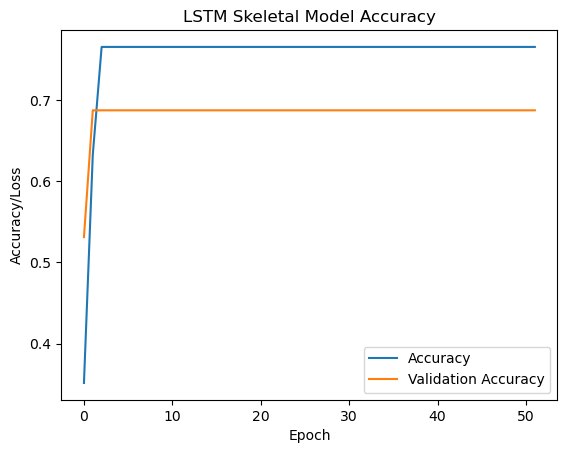

In [83]:
plt.plot(H.history["accuracy"])
plt.plot(H.history['val_accuracy'])
# plt.plot(hist.history['loss'])
# plt.plot(hist.history['val_loss'])
plt.title("LSTM Skeletal Model Accuracy")
plt.ylabel("Accuracy/Loss")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy"])
# plt.show()
plt.savefig("InceptionV3_GRU.jpg")

In [84]:
import matplotlib.ticker as mtick

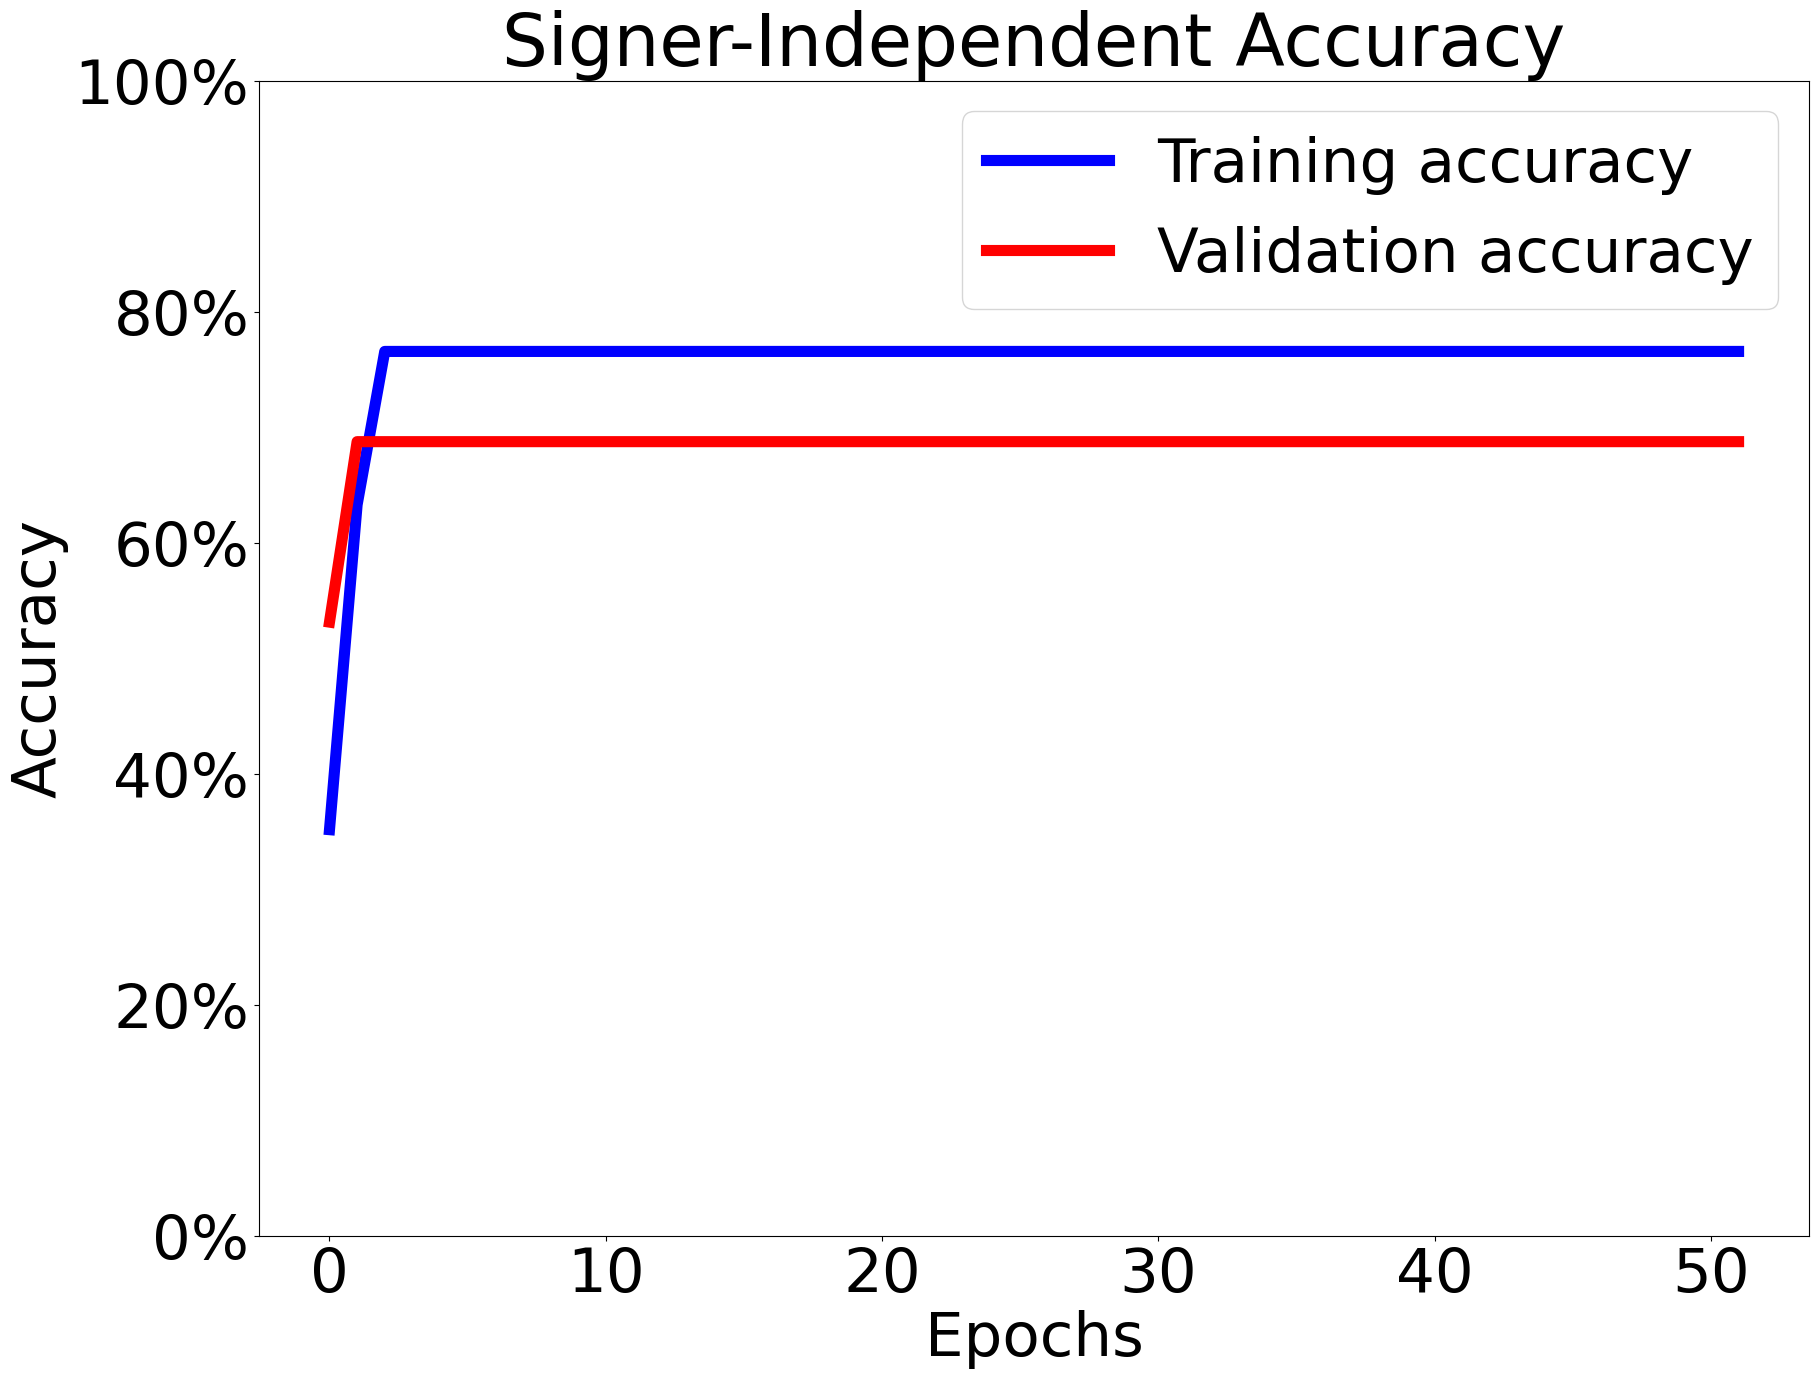

In [85]:
plt.figure(figsize=(20,15))
plt.plot( H.history["accuracy"], label = "Training accuracy", color='blue', linewidth=8)
plt.plot( H.history["val_accuracy"], label = "Validation accuracy", color='red', linewidth=8)

plt.title("Signer-Independent Accuracy", fontsize=52)
plt.ylim((0,1))
plt.xlabel("Epochs", fontsize=44)
plt.ylabel("Accuracy", fontsize=44)
# plt.legend()
plt.legend(fontsize=44)
plt.tick_params(labelsize=44)
ax = plt.subplot()
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=None, symbol='%', is_latex=False))

plt.savefig("signer_dependent.png")

In [86]:
def prepare_single_video(frames):
    frames = frames[None, ...]
    frame_mask = np.zeros(
        shape=(
            1,
            MAX_SEQ_LENGTH,
        ),
        dtype="bool",
    )
    frame_features = np.zeros(shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32")

    for i, batch in enumerate(frames):
        video_length = batch.shape[0]
        length = min(MAX_SEQ_LENGTH, video_length)
        for j in range(length):
            frame_features[i, j, :] = feature_extractor.predict(batch[None, j, :])
        frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked

    return frame_features, frame_mask

In [87]:
def sequence_prediction(path):
    class_vocab = label_processor.get_vocabulary()

    frames = load_video(os.path.join(test_videos, path))
    frame_features, frame_mask = prepare_single_video(frames)
    probabilities = sequence_model.predict([frame_features, frame_mask])[0]

    for i in np.argsort(probabilities)[::-1]:
        print(f"  {class_vocab[i]}: {probabilities[i] * 100:5.2f}%")
    return frames

In [88]:
def to_gif(images):
    converted_images = images.astype(np.uint8)
    imageio.mimsave("animation.gif", converted_images, duration=10)
    return embed.embed_file("animation.gif")

In [89]:
classes = ["Opaque", "Red", "Green", "Yellow", "Bright", "Light-blue", "Colors", "Red2", "Women", "Enemy", "Son", "Man",
           "Away", "Drawer", "Born", "Learn", "Call", "Skimmer", "Bitter", "Sweet milk", "Milk", "Water", "Food", "Argentina",
           "Urugauy", "Country", "Last name", "Where", "Mock", "Birthday", "Breakfast", "Photo", "Hungry", "Map",
           "Coin", "Music", "Ship", "None", "Name", "Patience", "Perfume", "Deaf", "Trap", "Rice", "Barbecue",
           "Candy", "Chewing-gum", "Spaghetti", "Yogurt", "Accept", "Thanks", "Shut down", "Appear", "To land",
           "Catch", "Help", "Dance", "Bathe", "Buy", "Copy", "Run", "Realize", "Give", "Find"]

In [90]:
def get_class_name(file_name):
    class_num = int(file_name[1:3])-1
    return classes[class_num]

Test video path: 003_010_004.mp4
Ground-truth Class: Green
1/1 [==============================] - 0s 20ms/step
  Green: 34.12%
  Red: 30.47%
  Opaque: 18.01%
  Yellow: 17.41%



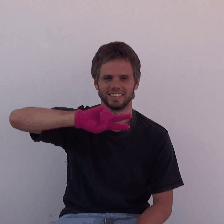

In [91]:
test_video = np.random.choice(test_df["video_name"].values.tolist())
# test_video = "045_010_002.mp4"
print(f"Test video path: {test_video}")
ground_truth = get_class_name(test_video)
print(f"Ground-truth Class: {ground_truth}")
test_frames = sequence_prediction(test_video)
to_gif(test_frames[:MAX_SEQ_LENGTH])